# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8422582948625777615
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5243339779544236191
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


'2.1.0'

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_16 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='None',
    classes=NUM_CLASSES
)
vgg_16.trainable = False
print(vgg_16.summary())
model = tf.keras.models.Sequential()
model.add(vgg_16)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### [5 points] Train Model

In [13]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

print(device_lib.list_local_devices())

history = None

with tf.device("GPU:0"):
    history = model.fit_generator(generator=train_batches, 
                steps_per_epoch=STEP_SIZE_TRAIN, 
                epochs=NUM_EPOCHS, 
                validation_data=(valid_batches),
                validation_steps=STEP_SIZE_VALID)

22
6
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14503462020301004352
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15476115882636019213
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
  ...
    to  
  ['...']


C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  ...
    to  
  ['...']
Train for 21 steps, validate for 5 steps
Epoch 1/100


C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 7s 325ms/step - loss: 6.0445 - accuracy: 0.2476 - val_loss: 1.3431 - val_accuracy: 0.3200
Epoch 2/100
21/21 [==============================] - 6s 278ms/step - loss: 2.1155 - accuracy: 0.3447 - val_loss: 1.5230 - val_accuracy: 0.4400
Epoch 3/100
21/21 [==============================] - 6s 281ms/step - loss: 1.7756 - accuracy: 0.4078 - val_loss: 1.3532 - val_accuracy: 0.3800
Epoch 4/100
21/21 [==============================] - 6s 277ms/step - loss: 1.3865 - accuracy: 0.4126 - val_loss: 1.1133 - val_accuracy: 0.5400
Epoch 5/100
21/21 [==============================] - 6s 281ms/step - loss: 1.3550 - accuracy: 0.3738 - val_loss: 1.0384 - val_accuracy: 0.5800
Epoch 6/100
21/21 [==============================] - 6s 275ms/step - loss: 1.2269 - accuracy: 0.4903 - val_loss: 0.9120 - val_accuracy: 0.6400
Epoch 7/100
21/21 [==============================] - 6s 283ms/step - loss: 1.2069 - accuracy: 0.4417 - val_loss: 1.0816 - val_accuracy: 0.5000
Epoch 8/100

21/21 [==============================] - 6s 286ms/step - loss: 0.8566 - accuracy: 0.6262 - val_loss: 0.8296 - val_accuracy: 0.6400
Epoch 59/100
21/21 [==============================] - 6s 297ms/step - loss: 0.8496 - accuracy: 0.6238 - val_loss: 0.6810 - val_accuracy: 0.6600
Epoch 60/100
21/21 [==============================] - 6s 292ms/step - loss: 0.7190 - accuracy: 0.6165 - val_loss: 0.6651 - val_accuracy: 0.6600
Epoch 61/100
21/21 [==============================] - 6s 290ms/step - loss: 0.7859 - accuracy: 0.6942 - val_loss: 0.6496 - val_accuracy: 0.7600
Epoch 62/100
21/21 [==============================] - 6s 290ms/step - loss: 0.7356 - accuracy: 0.6456 - val_loss: 0.6864 - val_accuracy: 0.7000
Epoch 63/100
21/21 [==============================] - 6s 291ms/step - loss: 0.7939 - accuracy: 0.6359 - val_loss: 0.6282 - val_accuracy: 0.6400
Epoch 64/100
21/21 [==============================] - 6s 288ms/step - loss: 0.7158 - accuracy: 0.6699 - val_loss: 0.7464 - val_accuracy: 0.6800
Epoch

#### [5 points] Plot Accuracy and Loss During Training

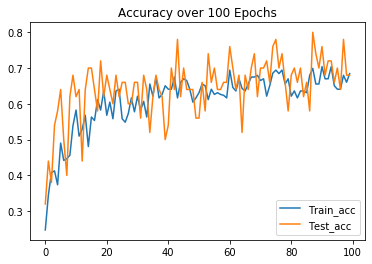

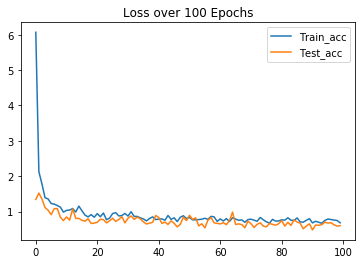

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label='Test_acc')
plt.title("Accuracy over 100 Epochs")
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['loss'], label='Train_acc')
plt.plot(history.history['val_loss'], label='Test_acc')
plt.title("Loss over 100 Epochs")
plt.legend(loc='upper right')

#### Testing Model

In [14]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
  ...
    to  
  ['...']
36/36 [==============================] - 1s 21ms/step - loss: 0.7652 - accuracy: 0.7222
Test loss: 0.7651614456279074
Test accuracy: 0.7222222


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.
270/270 [==============================] - 6s 20ms/step


(-15.0, 18.0)

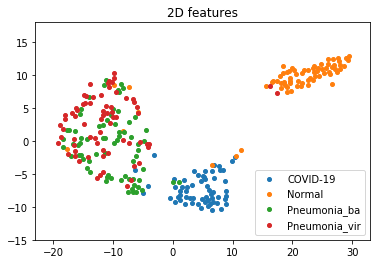

In [45]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_4').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

outputs = intermediate_layer_model.predict_generator(tsne_eval_generator,270,verbose=1)
label = tsne_eval_generator.classes
features = TSNE(n_components=2).fit_transform(outputs)

COVID_19_value_x, COVID_19_value_y = [], []
Normal_value_x, Normal_value_y = [], []
Pneumonia_ba_value_x, Pneumonia_ba_value_y = [], []
Pneumonia_vir_value_x, Pneumonia_vir_value_y = [], []

plt.figure()
for index in range(len(features)):
    if label[index] == 0:
        # COVID
        COVID_19_value_x.append(features[index, 0])
        COVID_19_value_y.append(features[index, 1])
    elif label[index] == 1:
        # normal
        Normal_value_x.append(features[index, 0])
        Normal_value_y.append(features[index, 1])
    elif label[index] == 2:
        # Pneumonia_bac
        Pneumonia_ba_value_x.append(features[index, 0])
        Pneumonia_ba_value_y.append(features[index, 1])
    elif label[index] == 3:
        # Pneumonia_vir
        Pneumonia_vir_value_x.append(features[index, 0])
        Pneumonia_vir_value_y.append(features[index, 1])

plt.scatter(COVID_19_value_x, COVID_19_value_y, s=16., marker='o', label="COVID-19")
plt.scatter(Normal_value_x, Normal_value_y, s=16., marker='o', label="Normal")
plt.scatter(Pneumonia_ba_value_x, Pneumonia_ba_value_y, s=16., marker='o', label="Pneumonia_ba")
plt.scatter(Pneumonia_vir_value_x, Pneumonia_vir_value_y, s=16., marker='o', label="Pneumonia_vir")

plt.legend(loc='lower right')
plt.xlim([-23.0, 33.0]) 
plt.ylim([-15.0, 18.0]) 

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->